In [20]:
import cantera as ct
from funcs.cell_size import CellSize
from funcs.specific_heat_matching import diluted_species_dict, match_adiabatic_temp
from sdtoolbox.postshock import CJspeed
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

In [ ]:
mech_default = "gri30.cti"
mechanisms = [
#     mech_default,
#     # GRI3 High Temp
#     # 53 species, 325 rxns, 300-5000 K, CH4 optimized
#     "gri30_highT.cti",
#     # San Diego Mech
#     # 57 species, 268 rxns, 300-5000 K, C???
#     "sandiego20161214.cti,"
#     # JetSurf2
#     # 348 species, 2163 rxns, 300-2000 K, n-alkane to n-dodecane
#     "JetSurf2.cti",  # crashed
#     # Blanquart
#     # 194 species, 1156 rxns, 300-3000 K, C1-C4
#     "Blanquart2018.cti",  # crashed
#     AramcoMech2.0
#     # 493 species, 2716 rxns, 300-2000 K, C1-C4
#     "aramco2.cti",  # paused due to long cj calc (~80 sec)
    # FFCM
    # 38 species, 291 rxns, 200-5000 K, C1-C4
#     "ffcm1.cti",  # lol it says C1-C4 but won't do propane, a C3 fuel...
]
p0 = 101325
t0 = 300
fuel = "C3H8"
oxidizer = "O2:1 N2:3.76"
phi = 1
diluents = [None, "CO2", "N2"]
mf_co2 = 0.01

matched_inert_mol_frac = match_adiabatic_temp(
    mech_default,
    fuel,
    oxidizer,
    phi,
    "CO2",
    mf_co2,
    "N2",
    t0,
    p0
)

dil_mfs = [0.0, mf_co2, matched_inert_mol_frac]
df = pd.DataFrame()
print("starting analysis")
with pd.HDFStore("cell_size_simulated.h5", "r+") as store:
    for mech in mechanisms:
        print("    starting %s"%mech)
        for dil, dil_mf in zip(diluents, dil_mfs):
            print("        {:s}: {:0.2f}".format(str(dil), dil_mf))
            case_series = pd.Series(
                index=[
                    "mechanism",
                    "diluent",
                    "dil_mf",
                    "cj_speed",
                    "westbrook",
                    "gavrikov",
                    "ng",
                    "cj_time",
                    "cell_time"
                ]
            )
            numeric_cols = (
                    "dil_mf",
                    "cj_speed",
                    "westbrook",
                    "gavrikov",
                    "ng",
            )
            case_series["mechanism"] = mech
            case_series["diluent"] = dil
            case_series["dil_mf"] = dil_mf
            gas = ct.Solution(mech)
            gas.set_equivalence_ratio(
                phi,
                fuel,
                oxidizer
            )
            if dil is not None:
                q = diluted_species_dict(
                    gas.mole_fraction_dict(),
                    dil,
                    dil_mf
                )
            else:
                q = gas.mole_fraction_dict()

            print("            starting cj")
            time_0 = time.perf_counter()
            cj_speed = CJspeed(
                p0,
                t0,
                q,
                mech
            )
            time_1 = time.perf_counter()
            print("            cj done: %1.3f seconds"%(time_1-time_0))
            case_series["cj_speed"] = cj_speed
            case_series["cj_time"] = pd.Timedelta(seconds=time_1 - time_0)

            cs = CellSize()
            print("            starting cell size")
            if mech == "Blanquart2018.cti":
                max_step_znd = 1e-9
            else:
                max_step_znd = 1e-4
            time_0 = time.perf_counter()
            sizes = cs(
                mech,
                t0,
                p0,
                fuel,
                oxidizer,
                phi,
                dil,
                dil_mf,
                cj_speed,
                max_step_znd=max_step_znd
            )
            time_1 = time.perf_counter()
            print("            cell size done: %1.3f seconds"%(time_1-time_0))
            # convert to mm for direct comparison
            case_series["westbrook"] = sizes["Westbrook"] * 1000
            case_series["gavrikov"] = sizes["Gavrikov"] * 1000
            case_series["ng"] = sizes["Ng"] * 1000
            case_series["cell_time"] = pd.Timedelta(seconds=time_1 - time_0)
            case_series = case_series.to_frame().T
            for c in numeric_cols:
                case_series[c] = pd.to_numeric(case_series[c])
            store.put(
                "results",
                case_series,
                format="table",
                append=True,
                min_itemsize=30
            )
            df = pd.concat(
                (df, case_series),
                sort=False,
                ignore_index=True
            )
            print("        done!")
        print("    done with %s"%mech)
        print()
print("done")

In [12]:
with pd.HDFStore("cell_size_simulated.h5", "r") as store:
    df = store.results
    
df["diluent"].where(df["diluent"].notna(), "None", inplace=True)
df

,mechanism,diluent,dil_mf,cj_speed,westbrook,gavrikov,ng,cj_time,cell_time
0,gri30.cti,None,0.000000,1799.835855,35.090486,1130.983736,65.322702,00:00:00.469704,00:00:06.968698
0,gri30.cti,CO2,0.010000,1785.824767,41.298007,1564.254360,75.623054,00:00:00.287777,00:00:08.048237
0,gri30.cti,N2,0.018875,1792.808984,38.320698,1292.242613,70.978270,00:00:00.667238,00:00:15.210961
0,gri30_highT.cti,None,0.000000,1799.795729,33.367689,998.847615,62.857466,00:00:00.566044,00:00:13.529422
0,gri30_highT.cti,CO2,0.010000,1785.783514,39.122380,1394.307209,72.783414,00:00:00.508654,00:00:08.861997
0,gri30_highT.cti,N2,0.018875,1792.771077,36.370586,1162.949933,68.317249,00:00:00.564895,00:00:15.963667
0,sandiego20161214.cti,None,0.000000,1807.124874,38.518235,538.313528,76.215911,00:00:00.508748,16:51:21.653362
0,sandiego20161214.cti,CO2,0.010000,1792.880001,44.808877,714.612258,87.786025,00:00:00.812440,16:54:28.443821
0,sandiego20161214.cti,N2,0.018875,1799.936701,41.902696,609.828055,82.687856,00:00:00.376739,16:07:25.545048


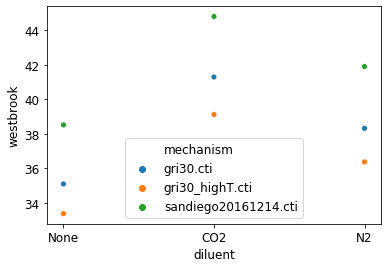

In [27]:
fig, ax = plt.subplots()
# for mech, df_mech in df.groupby("mechanism"):
sns.scatterplot(
    x="diluent",
    y="westbrook",
    hue="mechanism",
#     size=np.digitize(df.dil_mf, [0, 0.01]),
    data=df
)